# Topic Modeling Notebook

## Creating the dataset

In [1]:
!pip install simpletransformers==0.65.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.6/312.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.

In [2]:
import pandas as pd
import numpy as np
import csv
import re
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt
import seaborn as sn
# import os
# os.listdir('.')

The code below helps clean and organize text data. The **preprocess_text** function removes unwanted elements like newline indicators, URLs, and specific HTML tags. The **split_into_sentences** function then breaks down the text into sentences, ensuring they're manageable in length and free of mentions or hashtags. Lastly, there's a handy utility function called **contains_non_western_alphabet** that checks for non-Western alphabet characters in sentences. These functions work together to prep text for analysis or other language-related tasks, making sure it's tidy and ready for use.

In [3]:
def preprocess_text(text):
    # Remove newline indicators
    text = text.replace('\n', ' ')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove <br> symbols
    text = text.replace('<br /><br />', '')
    return text

# Function to split review into sentences
def split_into_sentences(text):
    # Using regex to split into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!|\>|\n)\s', text)
    # Filter out sentences containing @ or hashtags
    sentences = [sentence.strip() for sentence in sentences if '@' not in sentence and '#' not in sentence]
    # Filter out sentences with less than 9 or more than 25 words
    sentences = [sentence for sentence in sentences if 8 <= len(sentence.split()) <= 25]
    return sentences

def contains_non_western_alphabet(sentence):
    # Using regex to check for non-Western alphabet characters
    return bool(re.search(r'[^\x00-\x7F]', sentence))

def remove_punctuation(text):
    # Using regex to match a punctuation pattern
    punctuation_pattern = r'[^\w\s]'
    # Use the pattern to remove the punctuation
    return re.sub(punctuation_pattern, '', text)

Three different datasets are imported: one containing book reviews, another with IMDb movie reviews, and the third comprising FIFA football tweets. After importing, we apply preprossecing to each dataset and label them based on their content: book reviews are labeled as "book," IMDb movie reviews as "movie," and FIFA football tweets as "sports."

In [4]:

df_book = pd.read_csv('BookReviews.csv', encoding='latin-1')
print(df_book['ReviewContent'].nunique())
print(len(df_book))
df_book.head(2)

3982
5000


,ReviewContent
0,Good. It IS a page turner. You can read this b...
1,There are no words for how much I loathed this...


In [5]:
df_book['ReviewContent'] = df_book['ReviewContent'].apply(preprocess_text)

# Apply the function to each review and create a new DataFrame
# sentences_list = [sentence for review in df_book['ReviewContent'] for sentence in split_into_sentences(review)]
sentences_list = [sentence for review in df_book['ReviewContent'] for sentence in split_into_sentences(str(review)) if not contains_non_western_alphabet(sentence)]
book_sent_df = pd.DataFrame({'sentence': sentences_list})
book_sent_df['topic'] = 'book'

book_sent_df.head(10)

,sentence,topic
0,"You can read this book in one day, two at the ...",book
1,Entirely plot driven; the characters are paper...,book
2,You can figure out who-dunnit by the middle of...,book
3,There are no words for how much I loathed this...,book
4,"I poured myself another drink, I don't want t...",book
5,"I'm going to drink."" Not a direct quote from ...",book
6,I thought it went way longer than necessary.,book
7,I honestly can't figure out why everyone was i...,book
8,But because the book has received so many rave...,book
9,"If someone is digging around in something, the...",book


In [6]:
book_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  16242 non-null  object
 1   topic     16242 non-null  object
dtypes: object(2)
memory usage: 253.9+ KB


In [11]:
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.max_colwidth', None)  # Show full text in each cell

df_movie = pd.read_csv('IMDB Dataset.csv', error_bad_lines=False)
print(df_movie['review'].nunique())
df_movie.head(2)

<ipython-input-11-e0f48ccaf48c>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_movie = pd.read_csv('IMDB Dataset.csv', error_bad_lines=False)


49582


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [12]:
df_movie['review'] = df_movie['review'].apply(preprocess_text)
print(len(df_movie))

# Apply the function to each review and create a new DataFrame
# sentences_list = [sentence for review in df_movie['review'] for sentence in split_into_sentences(review)]
sentences_list = [sentence for review in df_movie['review'] for sentence in split_into_sentences(str(review)) if not contains_non_western_alphabet(sentence)]

movie_sent_df = pd.DataFrame({'sentence': sentences_list})
movie_sent_df['topic'] = 'movie'


movie_sent_df.head(10)

50000


,sentence,topic
0,One of the other reviewers has mentioned that ...,movie
1,"Trust me, this is not a show for the faint hea...",movie
2,This show pulls no punches with regards to dru...,movie
3,Forget pretty pictures painted for mainstream ...,movie
4,The filming technique is very unassuming- very...,movie
5,The actors are extremely well chosen- Michael ...,movie
6,A masterful production about one of the great ...,movie
7,"The plot is simplistic, but the dialogue is wi...",movie
8,Parents are divorcing & arguing like in real l...,movie
9,And then we have Jake with his closet which to...,movie


In [13]:
movie_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292357 entries, 0 to 292356
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  292357 non-null  object
 1   topic     292357 non-null  object
dtypes: object(2)
memory usage: 4.5+ MB


In [14]:
df_sports = pd.read_csv('FIFA_tweets.csv')
print(df_sports['Tweet'].nunique())
df_sports.head(5)

22360


,Unnamed: 0,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative


In [15]:
df_sports['Tweet'] = df_sports['Tweet'].apply(preprocess_text)

# Apply the function to each tweet and create a new DataFrame
# sentences_list = [sentence for tweet in df_sports['Tweet'] for sentence in split_into_sentences(tweet)]
sentences_list = [sentence for tweet in df_sports['Tweet'] for sentence in split_into_sentences(str(tweet)) if not contains_non_western_alphabet(sentence)]
sport_sent_df = pd.DataFrame({'sentence': sentences_list})
sport_sent_df['topic'] = 'sports'


sport_sent_df.head(10)

,sentence,topic
0,This is Canada: FIFA World Cup Opening Video,sports
1,"If the BBC cares so much about human rights, h...",sports
2,Why are they saying these during the opening c...,sports
3,"And like, will the mexican fans be able to scr...",sports
4,Football on a Monday morning at 9 and 12 and t...,sports
5,"Diversity, passion, incredible support- these ...",sports
6,"Love this, and I can't wait to cheer for my bo...",sports
7,"If the BBC cares so much about human rights, g...",sports
8,Why are they saying these during the opening c...,sports
9,Will not boycott watching a few chosen games.,sports


In [16]:
sport_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5609 entries, 0 to 5608
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  5609 non-null   object
 1   topic     5609 non-null   object
dtypes: object(2)
memory usage: 87.8+ KB


Next, we proceed to randomly sample 1700 entries from each dataset. Subsequently, we merge these sampled subsets into a single dataset.

In [17]:
book_sample = book_sent_df.sample(n=1700, random_state=2)
movie_sample = movie_sent_df.sample(n=1700, random_state=2)
sport_sample = sport_sent_df.sample(n=1700, random_state=2)

In [18]:
book_sample.head()

,sentence,topic
9400,All of the characters are hard to like and the...,book
4466,The twists were not surprising or that interes...,book
6568,I loved the different perspectives of the char...,book
14518,"I really enjoyed this book, it was hard to put...",book
3558,I never felt that I cared about any of the cha...,book


In [19]:
movie_sample.head()

,sentence,topic
80822,This is the only prison chiller worth tracking...,movie
277049,This is one of the best thrillers ever made in...,movie
72852,The old man adds to the humor of the story.,movie
198770,It is as simple a story for a movie as it can ...,movie
148757,The creative team behind Evan Almighty really ...,movie


In [20]:
sport_sample.head()

,sentence,topic
1097,Qatar are 45 minutes away from becoming the fi...,sports
4003,World Cup Football live score on Hamro Patro.,sports
1393,Enner Valencia is dominating out there like th...,sports
3222,What kind of check do we think the Qatari FA w...,sports
3878,Count down to the first match Ecuador 2- Qata...,sports


In [21]:
# Concatenate the sampled datasets into one
train = pd.concat([book_sample, movie_sample, sport_sample], ignore_index=True)
train = train.rename(columns={'sentence': 'text'})
train['text'] = train['text'].apply(lambda x: remove_punctuation(x.lower())) # removes punctuation and applies lowercasesing


# Define a mapping of topics to integer values
topic_mapping = {'sports': 0, 'movie': 1, 'book': 2}
# Map the topic values to integers
train['topic'] = train['topic'].map(topic_mapping)

In [22]:
train_bayes = train.copy() # make a copy of the training set for the bayes model before splitting it into train-dev set
train

,text,topic
0,all of the characters are hard to like and the...,2
1,the twists were not surprising or that interes...,2
2,i loved the different perspectives of the char...,2
3,i really enjoyed this book it was hard to put ...,2
4,i never felt that i cared about any of the cha...,2
...,...,...
5095,lamb steaks potatoes apple sauce and a fine wine,0
5096,then the contest is still on but ecuador showi...,0
5097,tbh qatar level up in infrastructure for the ...,0
5098,such a dodgy decision to disallow that perfect...,0


The test set is imported and the training set is split into a train-validation set.

In [23]:
# Import the test set
test = pd.read_csv('sentiment-topic-test.tsv',delimiter='\t')

# Define a mapping of topics to integer values
topic_mapping = {'sports': 0, 'movie': 1, 'book': 2}

# Map the topic values to integers
test['topic'] = test['topic'].map(topic_mapping)
test['text'] = test['text'].apply(lambda x: remove_punctuation(x.lower())) # removes punctuation and applies lowercasesing
# drop unnecessary columns
test = test.drop(['sentence id', 'sentiment'], axis=1)
test.head(10) # Test set

,text,topic
0,i wouldnt be caught dead watching the nfl if i...,0
1,chris odonnell stated that while filming for t...,1
2,the whole game was a rollercoaster ride but lo...,0
3,zendaya slayed in dune 2 as she does in all he...,1
4,while my favorite player was playing this matc...,0
5,my uncles brothers neighbors cats veterinarian...,2
6,he said that the great gatsby is the best nove...,2
7,i could not look away from this train wrck of ...,1
8,the film everything everywhere all at once fol...,1
9,i just finished reading pride and prejudice wh...,2


In [24]:
# train.head()

In [25]:
# make a train-validation split
train, dev = train_test_split(train, test_size=0.1, random_state=0,
                               stratify=train[['topic']])

In [26]:
train.head() # Training set

,text,topic
3511,ecuador just scored on qatar in the first few ...,0
1657,the author went to the trouble of describing t...,2
4878,there needs to be round the clock security for...,0
2154,beyond that kress isnt breaking into the music...,1
49,i couldnt finish this one and boy did i try,2


In [27]:
dev.head() # Validation set

,text,topic
687,it was slow at the beginning but it paid off i...,2
3239,as a fan of sciencefiction movies i have been ...,1
4834,the reputation of the beautiful game has turne...,0
1682,the plot becomes clear and compelling about 10...,2
892,i put it down several times but came back beca...,2


In [28]:
print(len(train))
print("train:", train[['topic']].value_counts(sort=False))
print()
print(len(dev))
print("dev:", dev[['topic']].value_counts(sort=False))

4590
train: topic
0        1530
1        1530
2        1530
dtype: int64

510
dev: topic
0        170
1        170
2        170
dtype: int64


# RoBERTa

Define model's configuration

In [29]:
# Model configuration # https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
model_args.evaluate_during_training=True # to perform evaluation while training the model
# (eval data should be passed to the training method)

model_args.num_train_epochs=10 # number of epochs
model_args.train_batch_size=46 # batch size
model_args.learning_rate=2e-5 # learning rate
model_args.max_seq_length=64 # maximum sequence length
# Note! Increasing max_seq_len may provide better performance, but training time will increase.


# Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=32 # how often you want to run validation in terms of training steps (or batches)


With this configuration, the training will terminate if the eval_loss on the evaluation data does not improve upon the best eval_loss by at least 0.01 for 2 consecutive evaluations.

An evaluation will occur once for every 32 training steps.

In [30]:
# Checking steps per epoch
steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print('Each epoch will have {:,} steps.'.format(steps_per_epoch))

Each epoch will have 100 steps.


Load the pre-trained model: model_type = roberta; model_name = roberta-base (specifies the exact architecture and trained weights to use)

In [31]:
model_roberta = ClassificationModel('roberta', 'roberta-base', num_labels=3, args=model_args, use_cuda=True) # CUDA is enabled


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Fine tuning the model

In [32]:
_, history = model_roberta.train_model(train, eval_df=dev)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:608: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

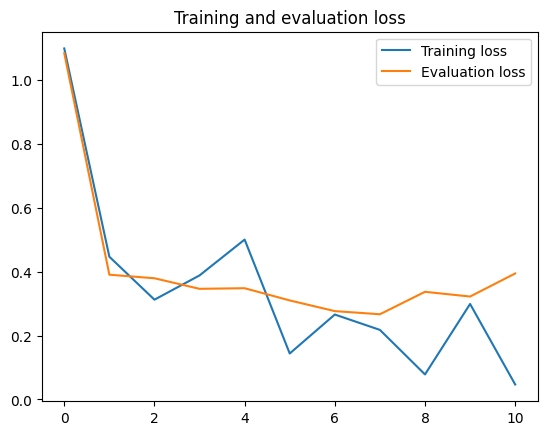

In [33]:
# Training and evaluation loss
train_loss_roberta = history ['train_loss']
eval_loss_roberta = history ['eval_loss']
plt.plot(train_loss_roberta, label='Training loss')
plt.plot(eval_loss_roberta, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()

In [34]:
# Evaluate RoBERta
result_roberta, model_outputs_roberta, wrong_predictions_roberta = model_roberta.eval_model(dev)
result_roberta

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1452: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/6 [00:00<?, ?it/s]

{'mcc': 0.835748135983844, 'eval_loss': 0.39423442880312604}

In [35]:
predicted_roberta, probabilities_roberta = model_roberta.predict(test.text.to_list())
test['predicted_roberta'] = predicted_roberta

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
# Result (note: your result can be different due to randomness in operations)
roberta_report = classification_report(test['topic'], test['predicted_roberta'] )
# print(classification_report(test['topic'], test['predicted_roberta'] ))
print(roberta_report)
test.head(10)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.67      1.00      0.80         4
           2       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.78      0.77        10
weighted avg       0.87      0.80      0.77        10

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.67      1.00      0.80         4
           2       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.78      0.77        10
weighted avg       0.87      0.80      0.77        10



,text,topic,predicted_roberta
0,i wouldnt be caught dead watching the nfl if i...,0,0
1,chris odonnell stated that while filming for t...,1,1
2,the whole game was a rollercoaster ride but lo...,0,0
3,zendaya slayed in dune 2 as she does in all he...,1,1
4,while my favorite player was playing this matc...,0,0
5,my uncles brothers neighbors cats veterinarian...,2,1
6,he said that the great gatsby is the best nove...,2,1
7,i could not look away from this train wrck of ...,1,1
8,the film everything everywhere all at once fol...,1,1
9,i just finished reading pride and prejudice wh...,2,2


# Naive Bayes

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report

In [45]:
train_bayes.head()




,text,topic
0,all of the characters are hard to like and the...,2
1,the twists were not surprising or that interes...,2
2,i loved the different perspectives of the char...,2
3,i really enjoyed this book it was hard to put ...,2
4,i never felt that i cared about any of the cha...,2


In [46]:
test.head(10)

,text,topic,predicted_roberta
0,i wouldnt be caught dead watching the nfl if i...,0,0
1,chris odonnell stated that while filming for t...,1,1
2,the whole game was a rollercoaster ride but lo...,0,0
3,zendaya slayed in dune 2 as she does in all he...,1,1
4,while my favorite player was playing this matc...,0,0
5,my uncles brothers neighbors cats veterinarian...,2,1
6,he said that the great gatsby is the best nove...,2,1
7,i could not look away from this train wrck of ...,1,1
8,the film everything everywhere all at once fol...,1,1
9,i just finished reading pride and prejudice wh...,2,2


### Establish a pipeline


In [47]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())  # Multinomial Naive Bayes classifier
])

### Define parameters for hyperparameter tuning

In [48]:
params = {
    'tfidf__max_df': (0.4 ,0.5, 0.6, 0.7, 0.8, 0.9, 1.0),  # Sets the maximum document frequency for the TF-IDF vectorizer
    'tfidf__min_df': (1, 2, 3 ,4 ,5),  # Sets the minimum document frequency for the TF-IDF vectorizer
    'tfidf__ngram_range': ((1, 1), (1, 2), (1,3), (1,4), (1,5)),  # Sets the n-gram range for the TF-IDF vectorizer
    'nb__alpha': (0.1, 0.25, 0.5, 0.75, 1.0)  # Sets the smoothing parameter for Naive Bayes
}

### Perform a gridsearch with k-fold cross validation for hyperparameter tuning

In [49]:
grid_search = GridSearchCV(pipeline, params, cv=10, n_jobs=-1, verbose=1) # k = 10
grid_search.fit(train_bayes['text'], train_bayes['topic'])

Fitting 10 folds for each of 875 candidates, totalling 8750 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': (0.1, 0.25, 0.5, 0.75, 1.0),
                         'tfidf__max_df': (0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
                         'tfidf__min_df': (1, 2, 3, 4, 5),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4),
                                                (1, 5))},
             verbose=1)

In [50]:
print("Best hyperparameters:", grid_search.best_params_) # Show best params

Best hyperparameters: {'nb__alpha': 0.25, 'tfidf__max_df': 0.6, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}


Evaluate the model with validation set

In [51]:
cv_scores = cross_val_score(grid_search.best_estimator_, train_bayes['text'], train_bayes['topic'], cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))


Cross-validation scores: [0.85196078 0.86372549 0.8627451  0.85392157 0.83823529]
Mean accuracy: 0.8541176470588235


Evaluate the model with the test set

In [52]:
predictions = grid_search.predict(test['text'])
nb_report = classification_report(test['topic'], predictions)
print("Classification Report on Test Set:")
print(classification_report(test['topic'], predictions))

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.60      0.75      0.67         4
           2       0.33      0.33      0.33         3

    accuracy                           0.60        10
   macro avg       0.64      0.58      0.60        10
weighted avg       0.64      0.60      0.61        10



In [53]:
print(roberta_report)
print(nb_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.67      1.00      0.80         4
           2       1.00      0.33      0.50         3

    accuracy                           0.80        10
   macro avg       0.89      0.78      0.77        10
weighted avg       0.87      0.80      0.77        10

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.60      0.75      0.67         4
           2       0.33      0.33      0.33         3

    accuracy                           0.60        10
   macro avg       0.64      0.58      0.60        10
weighted avg       0.64      0.60      0.61        10



In [1]:
# print(report_emb)
report_cols = roberta_report.split('\n')[0]
report_rob_lines = roberta_report.split('\n')[1:]
report_nb_lines = nb_report.split('\n')[1:]

print(report_cols)
for line_rob, line_nb in zip(report_rob_lines, report_nb_lines):
    if line_rob != '':
        print(line_rob, '(RoBERTa)')
        print(line_nb, '(Naive Bayes)')
        print()
    else:
        print(line_nb)

NameError: name 'roberta_report' is not defined